<a href="https://colab.research.google.com/github/Samarth-991/Computer-vision/blob/main/01_SuperImage_Resolution_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Super Resolution in OpenCV
Super resolution is the process of upscaling and or improving the details within an image. Often a low resolution image is taken as an input and the same image is upscaled to a higher resolution, which is the output. The details in the high resolution output are filled in where the details are essentially unknown.
https://towardsdatascience.com/deep-learning-based-super-resolution-without-using-a-gan-11c9bb5b6cd5

In [2]:
# !pip install --upgrade opencv-python
# !pip install --upgrade opencv-contrib-python

In [28]:
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import pandas as pd
import numpy as np
import time
import tensorflow as tf 
img_path ='/content/butterfly.JPG'

original imag shape 958 1316
Resized imag shape 256 256


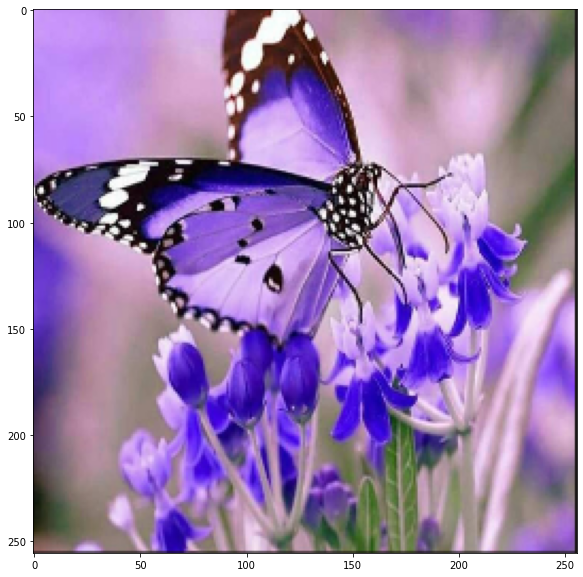

In [13]:
plt.figure(figsize=(10,10))
img = cv2.imread(img_path)
width = img.shape[0]
height = img.shape[1]
print('original imag shape',width,height)

Shape = (256,256)
img = cv2.resize(img,Shape)
plt.imshow(img)
print('Resized imag shape',img.shape[0],img.shape[1])

In [21]:
# FSRCNN model download 
# !wget https://github.com/Saafke/FSRCNN_Tensorflow/raw/master/models/FSRCNN_x2.pb

# EDSR model download 
# !wget https://raw.githubusercontent.com/Saafke/EDSR_Tensorflow/master/models/EDSR_x3.pb
FSRCNN_path = '/content/FSRCNN_x2.pb'


In [40]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

class FSRCNN:
    def __init__(self, model_name,img,scale):
        self.modelname= model_name
        self.img= img
        self.scale = scale
    
    def load_pb(self, path_to_pb):
        with tf.io.gfile.GFile(path_to_pb, "rb") as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
        with tf.Graph().as_default() as graph:
            tf.import_graph_def(graph_def, name='')
            return graph

    def normalize(self):
        # to ycrcb and normalize
        self.img_ycc = cv2.cvtColor(self.img, cv2.COLOR_BGR2YCrCb)
        img_y = self.img_ycc[:,:,0]
        floatimg = img_y.astype(np.float32) / 255.0
        return floatimg
    
    def get_tensor(self,graph,float_img):
        LR_input_ = float_img.reshape(1, float_img.shape[0], float_img.shape[1], 1)

        LR_tensor = graph.get_tensor_by_name("IteratorGetNext:0")
        HR_tensor = graph.get_tensor_by_name("NHWC_output:0")
        return LR_input_,HR_tensor,LR_tensor
        
    def process(self,graph,LR_input_,HR_tensor,LR_tensor):
        with tf.Session(graph=graph) as sess:
            print("Loading pb...")
            output = sess.run(HR_tensor, feed_dict={LR_tensor: LR_input_})
            # post-process
            Y = output[0]
            Y = (Y * 255.0).clip(min=0, max=255)
            Y = (Y).astype(np.uint8)
            start = time.time()
            print("Merge with Chrominance channels Cr/Cb")
            Cr = np.expand_dims(cv2.resize(self.img_ycc[:,:,1], None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_CUBIC), axis=2)
            Cb = np.expand_dims(cv2.resize(self.img_ycc[:,:,2], None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_CUBIC), axis=2)
            HR_image = (cv2.cvtColor(np.concatenate((Y, Cr, Cb), axis=2), cv2.COLOR_YCrCb2BGR))
            end = time.time()
            print("time taken to process fsrcnn {:.6f} seconds".format(end-start))
            bicubic_image = cv2.resize(img, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_CUBIC)
            return HR_image,bicubic_image



In [41]:
fssr = FSRCNN('frcnn',img,2)
graph = fssr.load_pb(FSRCNN_path)
float_img = fssr.normalize()
LR_input_,HR_tensor,LR_tensor = fssr.get_tensor(graph,float_img)
FRCNN_image , bicubic_image = fssr.process(graph,LR_input_,HR_tensor,LR_tensor)


Loading pb...
Merge with Chrominance channels Cr/Cb
time taken to process fsrcnn 0.0023581981658935547 seconds


(512, 512, 3)


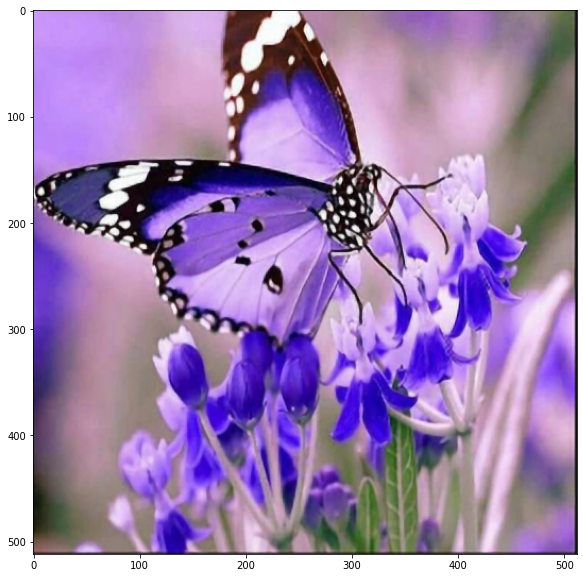

In [42]:
plt.figure(figsize=(10,10))
plt.imshow(FRCNN_image)
print(FRCNN_image.shape)

(512, 512, 3)


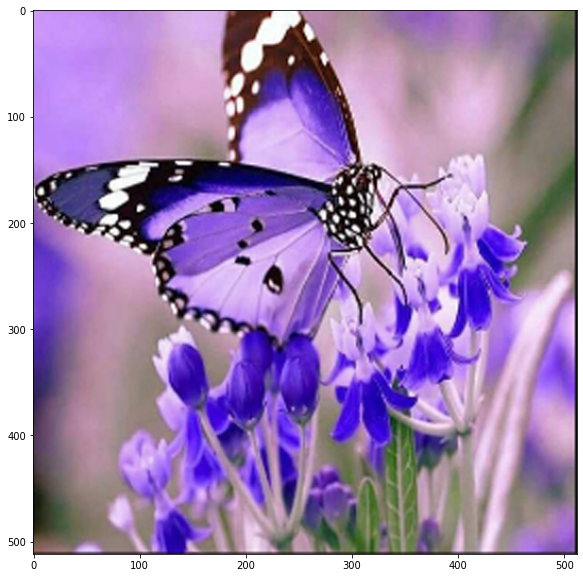

In [43]:
plt.figure(figsize=(10,10))
plt.imshow(bicubic_image)
print(bicubic_image.shape)

In [45]:
# EDSR Image Super-resolution
EDSR_path = '/content/EDSR_x3.pb'

original imag shape 958 1316
(480, 480, 3)


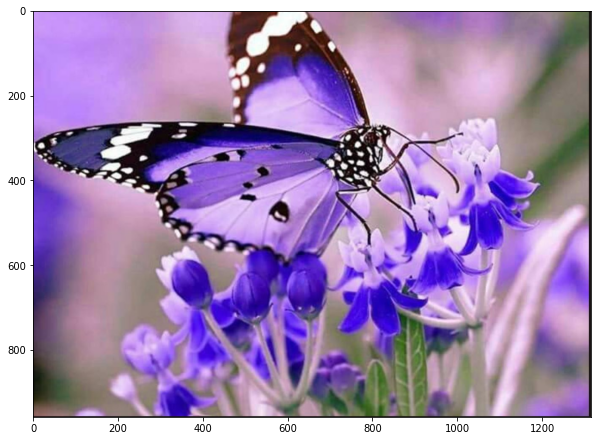

In [44]:
plt.figure(figsize=(10,10))
org_img = cv2.imread(img_path)
width = org_img.shape[0]
height = org_img.shape[1]

print('original imag shape',width,height)
plt.imshow(org_img)

# shape should be divisble by 3
img = cv2.resize(org_img,(480,480))
print(img.shape)

In [49]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

class EDSR:
    def __init__(self, model_path,img,scale):
        self.path_to_pb= model_path
        self.img= img
        self.scale = scale
        self.mean = [103.1545782, 111.561547, 114.35629928]

    def load_pb(self,):
        with tf.io.gfile.GFile(self.path_to_pb, "rb") as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
        with tf.Graph().as_default() as graph:
            tf.import_graph_def(graph_def, name='')
            return graph
    
    def process(self,graph):
        floatimg = self.img.astype(np.float32)/255.0
        LR_input_ = floatimg.reshape(1, floatimg.shape[0], floatimg.shape[1], 3)
        LR_tensor = graph.get_tensor_by_name("IteratorGetNext:0")
        HR_tensor = graph.get_tensor_by_name("NHWC_output:0")

        with tf.Session(graph=graph) as sess:
            print("Loading pb...")
            output = sess.run(HR_tensor, feed_dict={LR_tensor: LR_input_})
            Y = output[0]
            start = time.time()
            HR_image = (Y + self.mean).clip(min=0, max=255)
            HR_image = (HR_image).astype(np.uint8)
            end= time.time()
            print("time taken to process fsrcnn {:.6f} seconds".format(end-start))
            bicubic_image = cv2.resize(self.img, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_CUBIC)
            return HR_image,bicubic_image

In [50]:
edsr = EDSR(EDSR_path,img,scale=2)
# load EDSR model
edsr_model = edsr.load_pb()

Loading pb...
time taken to process fsrcnn 0.055373 seconds
(1440, 1440, 3)


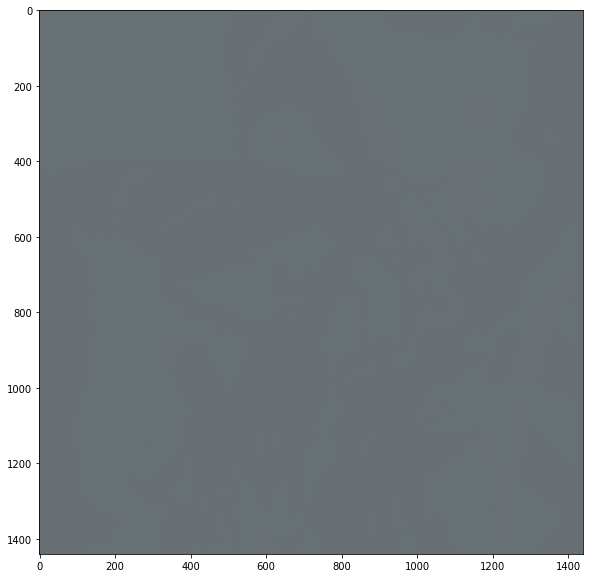

In [52]:
EDSR_image,bicubic_image = edsr.process(edsr_model)

plt.figure(figsize=(10,10))
plt.imshow(EDSR_image)
print(EDSR_image.shape)